<a href="https://colab.research.google.com/github/prateekjoshi565/ULMFiT_Text_Classification/blob/master/ULMFiT_fastai_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's install PyTorch and fastai libraries first. You have to repeat this step every time you restart this notebook in colab.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.6MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62b52000 @  0x7f6114c162a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 133kB 7.7MB/s 
    100% |████████████████████████████████| 61kB 25.3MB/s 
    100% |████████████████████████████████| 163kB 19.2MB/s 
    100% |████████████████████████████████| 112kB 24.7MB/s 
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built bottleneck
torchvision-nightly 0.2.1 has requirement pillow>=4.1.

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
#import dataset
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [0]:
# create a dataframe
df = pd.DataFrame({'label':dataset.target,
                   'text':dataset.data})

In [0]:
df.shape

(11314, 2)

In [0]:
df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

In [0]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

### Preprocessing

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') 

In [0]:
# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df['text'] = detokenized_doc

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [0]:
df_trn.shape, df_val.shape

((710, 2), (474, 2))

### Data Preparation

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)

In [0]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.506149,0.289562,0.905063


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


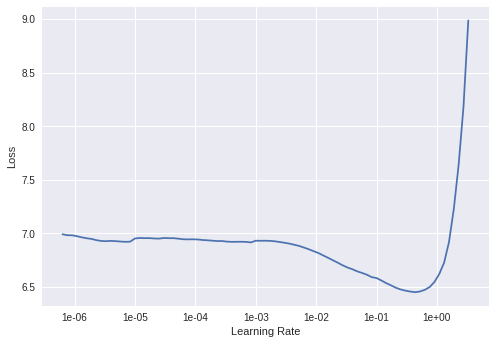

In [0]:
learn.recorder.plot()

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.7)
learn.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


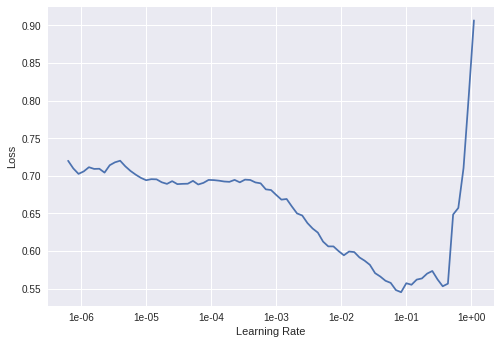

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.572245,0.354939,0.894515
